In [ ]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib  

**Some helper methods**
 - computing losses divided by parts of body (purely for comparison purpose -> not for training loss backprop)
    - will be part of the pkl file that gets generated (will save as *all.losses.{version#}.pkl**)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

### CHANGE DIRECTORY LOCATION ###
# Make this point to the correct location. Need to connect the sharedDrive to my Drive. 
# Follow instruction here https://stackoverflow.com/a/54352105
%cd '/content/drive/My Drive/DLF2020/dlf2020'
%ls
output_folder = "src/Bhagyashree Experiments/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1XCqSJ4wOA_0YGBeiVFwWnOq2NUCpBEMO/DLF2020/dlf2020
 all.losses.v1.pkl            README.md
 app.py                       requirements.txt
 data/                        src/
'Data Collection Module'/     trained_transformer_100.pkl
 gan.all.losses.v1.pkl        trained_transformer_204.pkl
 output_movies/               trained_transformer_model_300.pkl
 output_movies_b/             transformer.all.losses.v1.pkl
 quarter_data_50_epochs.pkl


In [3]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt

import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pickle
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
# from torchtext.vocab import GloVe
# glove_embedding = GloVe(dim = 100)
# print(torch.cat((glove_embedding['apart'], torch.zeros(2))))
# print(glove_embedding['apart'].shape)

In [4]:
# use cuda is available
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
# creates a embedding dictionary of word to embedding. 
#We want 250 dimension so concatennating two embedding txt files (one with 200 and other with 50 dimensions)
embeddings_dict = {}
with open("data/interim/glove.6B.200d.txt", 'r') as f: 
      for line in f:
          values = line.split()
          word = values[0]
          vector = np.asarray(values[1:], "float32")
          embeddings_dict[word] = vector
with open("data/interim/glove.6B.50d.txt", 'r') as f: 
      for line in f:
          values = line.split()
          word = values[0]
          vector = np.asarray(values[1:], "float32")
          embeddings_dict[word] = np.append(embeddings_dict[word],vector)

## Classes needed to construct the model

In [6]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many 
    other models.
    """
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, tgt, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(src)
        output = self.decoder(tgt, memory, tgt_mask)
        
        return output

In [7]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [8]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N = 1):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        
    def forward(self, x):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [10]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [11]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.feed_forward = feed_forward
        self.size = size

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        return self.feed_forward(x)

In [12]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N, continuous_embedding, counter_embedding):
        super(Decoder, self).__init__()
        self.continuous_embedding = continuous_embedding
        self.counter_embedding = counter_embedding
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, tgt_mask):
        continuous_embedding = self.continuous_embedding(x[:,:,:-counter_index:])
        counter_embedding = torch.cat((self.counter_embedding(x[:,:,-counter_index:-counter_index+1]),torch.zeros(x.shape[0],x.shape[1],counter_index-1).to(device)), axis=2)
        continuous_embedding = torch.cat((continuous_embedding,counter_embedding), axis=2)
        x = continuous_embedding
        
        for layer in self.layers:
            x = layer(x, memory, tgt_mask)
        return self.norm(x)

        # with counter embedding layer = batch_size x 185
        # continuous_embedding = self.continuous_embedding(x[:,:,:360:])
        # counter_embedding = torch.cat((self.counter_embedding(x[:,:,360:361].squeeze()).unsqueeze(2),torch.zeros((x.shape[0],x.shape[1],3)).cuda()),axis=2)
        # input = torch.cat((continuous_embedding,counter_embedding), axis=2)
        # for layer in self.layers:
        #     input = layer(input, memory, tgt_mask)
        # return self.norm(input)

In [13]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # todo check src_mask can be None or should be something valid
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, None))
        return self.sublayer[2](x, self.feed_forward)

In [14]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [15]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

In [16]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [17]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model_input, d_model_output, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model_input, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model_output)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [18]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) 
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

## Full Model

In [19]:
def make_model(N=6, d_model_input=102, d_model_output=102, d_ff=1024, h=5, dropout=0.1):
    # TRY different h values and N values remember  
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model_output, dropout)
    # ff_encoder = PositionwiseFeedForward(d_model_input, d_model_output, d_ff, dropout)
    # ff_encoder = nn.Sequential(nn.Linear(d_model_input, 512), nn.ReLU(), nn.Linear(512, d_model_output))
    ff_encoder = nn.Linear(d_model_input, d_model_output)
    ff_decoder = PositionwiseFeedForward(d_model_output, d_model_output, d_ff, dropout)
    position = PositionalEncoding(d_model_output, dropout)
    continuous_embedding = nn.Sequential(nn.Linear(d_model_output-counter_index, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model_output-counter_index))
    # counter_embedding = nn.Sequential(nn.Linear(max_sequence_length,max_sequence_length), nn.Sigmoid())
    counter_embedding = nn.Linear(1,1)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model_input, c(ff_encoder), dropout), N=1),
        Decoder(DecoderLayer(d_model_output, c(attn), c(attn), c(ff_decoder), dropout), N, continuous_embedding, counter_embedding))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [20]:
# Small example model.
# tmp_model = make_model()
# tmp_model

# Training

This section describes the training regime for our models.


In [21]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.encoder.layers[0].size, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [22]:
import numpy
def normalization(Xx, Xy):
  T, n = Xx.shape
  sum0 = T * n
  sum1Xx = np.sum(np.sum(Xx))
  sum2Xx = np.sum(np.sum(Xx * Xx))
  sum1Xy = np.sum(np.sum(Xy))
  sum2Xy = np.sum(np.sum(Xy * Xy))
  mux = sum1Xx / sum0
  muy = sum1Xy / sum0
  sum0 = 2 * sum0
  sum1 = sum1Xx + sum1Xy
  sum2 = sum2Xx + sum2Xy
  mu = sum1 / sum0
  sigma2 = (sum2 / sum0) - mu * mu
  if sigma2 < 1e-10:
    simga2 = 1e-10
  sigma = math.sqrt(sigma2)
  return (Xx - mux) / sigma, (Xy - muy) / sigma

def prune(Xx, Xy, Xw, watchThis, threshold, dtype):
  T = Xw.shape[0]
  N = Xw.shape[1]
  Yx = numpy.zeros((T, N), dtype=dtype)
  Yy = numpy.zeros((T, N), dtype=dtype)
  Yw = numpy.zeros((T, N), dtype=dtype)
  for t in range(T):
    sum0 = 0
    sum1 = 0.0
    for i in watchThis:
      sum0 = sum0 + 1
      sum1 = sum1 + Xw[t, i]
    Ew = sum1 / sum0
    if Ew >= threshold:
      for i in range(N):
        Yx[t, i] = Xx[t, i]
        Yy[t, i] = Xy[t, i]
        Yw[t, i] = Xw[t, i]
  return Yx, Yy, Yw


def interpolation(Xx, Xy, Xw, threshold, dtype):
  T = Xw.shape[0]
  N = Xw.shape[1]
  Yx = numpy.zeros((T, N), dtype=dtype)
  Yy = numpy.zeros((T, N), dtype=dtype)
  for t in range(T):
    for i in range(N):
      a1 = Xx[t, i]
      a2 = Xy[t, i]
      p = Xw[t, i]
      sumpa1 = p * a1
      sumpa2 = p * a2
      sump = p
      delta = 0
      while sump < threshold:
        change = False
        delta = delta + 1
        t2 = t + delta
        if t2 < T:
          a1 = Xx[t2, i]
          a2 = Xy[t2, i]
          p = Xw[t2, i]
          sumpa1 = sumpa1 + p * a1
          sumpa2 = sumpa2 + p * a2
          sump = sump + p
          change = True
        t2 = t - delta
        if t2 >= 0:
          a1 = Xx[t2, i]
          a2 = Xy[t2, i]
          p = Xw[t2, i]
          sumpa1 = sumpa1 + p * a1
          sumpa2 = sumpa2 + p * a2
          sump = sump + p
          change = True
        if not change:
          break
      if sump <= 0.0:
        sump = 1e-10
      Yx[t, i] = sumpa1 / sump
      Yy[t, i] = sumpa2 / sump
  return Yx, Yy, Xw

def convList2Array(lst): 
  T, dim = lst[0].shape
  a = []
  for t in range(T):
    a_t = []
    for i in range(dim):
      for j in range(len(lst)):
        a_t.append(lst[j][t, i])
    a.append(a_t)
    # keep output of 20 frames
    # downsample_rate = dim // 20
    # a = numpy.asarray(a)
    # print(dim, downsample_rate)
    # a = a[0:dim:downsample_rate,:]
  return numpy.asarray(a)

In [23]:
class PoseDataset(Dataset):
    """PoseDataset."""
    def __init__(self, data, transform=None):          
        self.embeddings = torch.tensor(data['embedding'], dtype=torch.float32)
        self.poses = torch.tensor(data['skeleton'], dtype=torch.float32)
        print(len(self.embeddings),len(self.embeddings[0]),len(self.poses),len(self.poses[0]), len(self.poses[0][0]))
        
    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        sample = {'embedding': self.embeddings[idx], 'poses': self.poses[idx]}
        return sample


"""
reads trainable data. It is a dictionary of the form: 
{
  skeleton: poses 
  embedding: word embeddings of size 250
  video: list of videoids
  gloss: list of words
}
Data is about 3GB so takes a sec to read it.
"""
with open('../Training Data/trainable.2ddata.with.face.firsthalf.pkl', 'rb') as f:
  first_data = pickle.load(f)
with open('../Training Data/trainable.2ddata.with.face.secondhalf.pkl', 'rb') as f:
 second_data = pickle.load(f)
data = {
    "skeleton": np.concatenate((first_data["skeleton"], second_data["skeleton"])),
    "embedding": np.concatenate((first_data["embedding"], second_data["embedding"])),
    "gloss": np.concatenate((first_data["gloss"], second_data["gloss"])),
    "video": np.concatenate((first_data["video"], second_data["video"])),
}
# data = {
#     "skeleton": first_data["skeleton"],
#     "embedding": first_data["embedding"],
#     "gloss": first_data["gloss"],
#     "video": first_data["video"],
# }

dataset = PoseDataset(data)

12653 250 12653 176 250


In [24]:
batch_size = 20
validation_split = .2
shuffle_dataset = True
random_seed= 42
pad = 2
counter_index = 10
max_sequence_length = max([len(row) for row in data["skeleton"]])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [25]:
def plot_losses(loss_list):
  ax1 = plt.subplot(111)
  ax1.plot(loss_list)
  ax1.title.set_text("Transformer losses")
  plt.show()

In [26]:
def compute_skeleton_losses_by_parts(pred, ground_truth, criterion):
  with torch.no_grad():
    # torso (first 16)
    torso_loss = criterion(pred[:, :, 0:16], ground_truth[:, :, 0:16])
    # hand (next 42+42 for left and right)
    hand_loss = criterion(pred[:, :, 16:16+84], ground_truth[:, :, 16:16+84])
    # face (next 140)
    face_loss = criterion(pred[:, :, 16+84:16+84+140], ground_truth[:, :, 16+84:16+84+140])
    return torso_loss, hand_loss, face_loss

### Main Method for training an epoch for transformer model
Updated this to return the total loss and losses divided by body parts

In [27]:
def train_epoch(train_iter, model, criterion, opt, epoch, transpose=False):
    model.train()
    losses = 0
    torso_losses = 0
    hand_losses = 0
    face_losses = 0
    for i, batch in enumerate(train_iter):
        src = Variable(batch['embedding'], requires_grad=False).to(device)
        trg = Variable(batch['poses'],requires_grad=False).to(device)
        #begin_frame = torch.zeros((trg.shape[0],1,trg.shape[2])).cuda()
        begin_frame = src.unsqueeze(1).to(device)
        trg = torch.cat((begin_frame, trg),axis=1).cuda()

        tgt_mask = Variable(subsequent_mask(max_sequence_length + 1),requires_grad=False).to(device)
        padded_mask = (trg[:,:,-counter_index] != pad).unsqueeze(-2)
        other_mask = (padded_mask & tgt_mask).cuda()
        # todo check the way parameters are passed as expected
        # out = model.forward(src, trg[:, :-1], trg_mask[:, :-1, :-1])
        # TRY : changing the dimension of noise and accordingly change the model
        noise = Variable(torch.randn((src.shape[0], src.shape[1])).cuda())
        src = torch.cat((src,noise),1).cuda()
        out = model.forward(src, trg, other_mask)
        # padded_mask = padded_mask.squeeze(1).unsqueeze(2)
        # padded_mask = tile(padded_mask,2,102)

        # padding = torch.zeros_like(trg)
        # # change out to only include loss from real frames
        # out = torch.where(padded_mask,out,padding)
  
        # out = torch.where(out[:,:,360:361]<=1, out, torch.zeros_like(out))
        # loss_counter = criterion(out[:,:,360:361], trg[:,:,360:361])
        # loss_pose = criterion(out[:,:,:360:], trg[:,:,:360:]) 
        # total_loss = 0.05 * loss_counter +  loss_pose
        total_loss = criterion(out[:,:-1], trg[:,1::])


        losses += total_loss

        # torso_loss = criterion(out[:,:,:16:], trg[:,:,:16:])
        # finger_loss = criterion(out[:,:,16::], trg[:,:,16::])
        # total_loss = torso_loss + 10 * finger_loss

        total_loss.backward()
        model_opt.step()
        model_opt.optimizer.zero_grad()

        
        torso_loss, hand_loss, face_loss = compute_skeleton_losses_by_parts(pred=out[:, :-1], ground_truth=trg[:, 1::], criterion=criterion)
        torso_losses += torso_loss
        hand_losses += hand_loss
        face_losses += face_loss 

        if i % 10 == 1:
            print(i, epoch, total_loss, model_opt._rate)
        if (i % 100 == 0 and epoch % 100 == 0):
            trim_frames(out[1],trg[1], output_folder+'/output_movies/mov_%d_%d.mp4'%(epoch, i), output_folder+'/output_movies/gt_mov_%d_%d.mp4'%(epoch, i) )
    return losses/len(train_iter), {"torso": torso_losses / len(train_iter), "hand": hand_losses / len(train_iter), "face": face_losses / len(train_iter)}



In [28]:
def valid_epoch_transformer(valid_iter, model, criterion):
    model.eval()
    total_loss = 0
    total_words = 0
    total_torso_loss = 0
    total_hand_loss = 0
    total_face_loss = 0
    with torch.no_grad():  
      for i, batch in enumerate(valid_iter):
        src = Variable(batch['embedding'], requires_grad=False).to(device)
        trg = Variable(batch['poses'],requires_grad=False).to(device)
        begin_frame = src.unsqueeze(1).to(device)
        trg = torch.cat((begin_frame, trg),axis=1)
        tgt_mask = Variable(subsequent_mask(max_sequence_length + 1),requires_grad=False).to(device)
        padded_mask = (trg[:,:,-counter_index] != pad).unsqueeze(-2)
        other_mask = (padded_mask & tgt_mask).to(device)
        noise = Variable(torch.randn((src.shape[0], src.shape[1])).cuda())
        src = torch.cat((src,noise),1)
        out = model.forward(src, trg, other_mask)
        
        torso_loss, hand_loss, face_loss = compute_skeleton_losses_by_parts(pred=out[:, :-1], ground_truth=trg[:, 1::], criterion=criterion)
        total_torso_loss += torso_loss
        total_hand_loss += hand_loss
        total_face_loss += face_loss

        total_loss += criterion(out[:,:-1], trg[:,1::])
        total_words += trg.shape[0]
    return  total_loss / len(valid_iter), {"torso": total_torso_loss / len(valid_iter), "hand": total_hand_loss / len(valid_iter), "face": total_face_loss / len(valid_iter)}

In [29]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

def trim_frames(out,trg,v_name1,v_name2):
    out = out.detach().float()
    trg = trg.detach().float()
    padded_mask = (trg[:,-counter_index] != pad).unsqueeze(1).cuda()
    padded_mask = tile(padded_mask,1,trg.shape[-1])
    padding = torch.fill_(torch.zeros_like(trg),pad).float()
    # change out to only include loss from real frames
    out = torch.where(padded_mask,out,padding)
    trg = torch.where(padded_mask,trg,padding)
    get_video(out,v_name1)
    get_video(trg,v_name2)

def get_video(video, video_name):
    video = video.cpu().detach()
    # total=[]
    # video = sorted(video, key=lambda v: v[100]) #sort by predicted counter value (element at index 360)
    print(max([v[-counter_index] for v in video]))
    total = video
    # for output in video:
    #   o = []
    #   for i in range(0,len(output)-2,2):
    #     o.append(output.data[i])
    #     o.append(output.data[i+1])
    #   total.append(o)

    fig = plt.figure(figsize=(8, 6),dpi = 90)
    ax  = fig.add_subplot(111)

    def drawLine(i,j,pose,ax,c):
      x_points, y_points = [pose[i*2],pose[j*2]],[-pose[i*2+1].item(),-pose[j*2+1].item()]
      if (x_points[0] == pad and x_points[1] == pad and y_points[0] == pad and y_points[1] == pad ):
        return
      ax.plot(x_points, y_points, color = c)

    lines4disp = ((0,1),(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(7,8),(8,9),(8,13),(8,17),(8,21),(8,25),(9,10),(10,11),(11,12),(13,14),(14,15),(15,16),(7,18),(18,19),(19,20),(21,22),(22,23),(23,24),(25,26),(26,27),(27,28),(4,29),(29,30),(29,34),(29,38),(29,42),(29,46),(30,31),(31,32),(32,33),(34,35),(35,36),(36,37),(29,38),(38,39),(39,40),(40,41),(42,43),(43,44),(44,45),(46,47),(47,48),(48,49))
    colors = [[0.7679950277787857, 0.8140632424247183, 0.1836916245078214], [0.13742703336040774, 0.1981885169234251, 0.8548538856836679], [0.9049254312055657, 0.3121208219109287, 0.6572391790595994], [0.9049254312055657, 0.3121208219109287, 0.6572391790595994], [0.4281613823587963, 0.5198067942453158, 0.04881431792744795], [0.6951947487387875, 0.3050133218320593, 0.5940431930484983], [0.6951947487387875, 0.3050133218320593, 0.5940431930484983], [0.9631509182494915, 0.7601350926127199, 0.9158105111858872], [0.540093600946819, 0.4134848498957274, 0.951462871318168], [0.6838403230574046, 0.4756738593157622, 0.3938623515420554], [0.18887112478350232, 0.6188683735060204, 0.5816041524033629], [0.40073490295802816, 0.5648227581867659, 0.8615841763393434], [0.15175417168319372, 0.3084894870088224, 0.609588649020386], [0.540093600946819, 0.4134848498957274, 0.951462871318168], [0.540093600946819, 0.4134848498957274, 0.951462871318168], [0.540093600946819, 0.4134848498957274, 0.951462871318168], [0.6838403230574046, 0.4756738593157622, 0.3938623515420554], [0.6838403230574046, 0.4756738593157622, 0.3938623515420554], [0.6838403230574046, 0.4756738593157622, 0.3938623515420554], [0.18887112478350232, 0.6188683735060204, 0.5816041524033629], [0.18887112478350232, 0.6188683735060204, 0.5816041524033629], [0.18887112478350232, 0.6188683735060204, 0.5816041524033629], [0.40073490295802816, 0.5648227581867659, 0.8615841763393434], [0.40073490295802816, 0.5648227581867659, 0.8615841763393434], [0.40073490295802816, 0.5648227581867659, 0.8615841763393434], [0.15175417168319372, 0.3084894870088224, 0.609588649020386], [0.15175417168319372, 0.3084894870088224, 0.609588649020386], [0.15175417168319372, 0.3084894870088224, 0.609588649020386], [0.40669701393116786, 0.4593409814305951, 0.7190514200349438], [0.9128003543496577, 0.7220320407885213, 0.8698440476355693], [0.8250105020150548, 0.93518490949386, 0.6175323650912076], [0.4962125528346799, 0.04202215286547295, 0.19486196662165078], [0.7051432161645197, 0.25180882135411564, 0.6180191768446801], [0.7293927436948651, 0.32521532653176055, 0.9434810812953591], [0.9128003543496577, 0.7220320407885213, 0.8698440476355693], [0.9128003543496577, 0.7220320407885213, 0.8698440476355693], [0.9128003543496577, 0.7220320407885213, 0.8698440476355693], [0.8250105020150548, 0.93518490949386, 0.6175323650912076], [0.8250105020150548, 0.93518490949386, 0.6175323650912076], [0.8250105020150548, 0.93518490949386, 0.6175323650912076], [0.4962125528346799, 0.04202215286547295, 0.19486196662165078], [0.4962125528346799, 0.04202215286547295, 0.19486196662165078], [0.4962125528346799, 0.04202215286547295, 0.19486196662165078], [0.7051432161645197, 0.25180882135411564, 0.6180191768446801], [0.7051432161645197, 0.25180882135411564, 0.6180191768446801], [0.7051432161645197, 0.25180882135411564, 0.6180191768446801], [0.7293927436948651, 0.32521532653176055, 0.9434810812953591], [0.7293927436948651, 0.32521532653176055, 0.9434810812953591], [0.7293927436948651, 0.32521532653176055, 0.9434810812953591]]

    def animate2(i):
      ax.clear()
      for s,c in zip(lines4disp,colors):
        drawLine(s[0],s[1],np.array(total[i]),ax,c)
      ax.scatter(np.array(total[i][100:-counter_index:2]), -1 * np.array(total[i][101:-counter_index:2]))

    # create animation
    ani = animation.FuncAnimation(fig, animate2, frames=range(1, len(total)), interval=100, repeat=False)
    ani.save(video_name)

    # start animation
    plt.show()

In [30]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).cuda()
    return torch.index_select(a, dim, order_index)

In [31]:
def plot_losses(loss_list, plot_name = "Transformer losses"):
  ax1 = plt.subplot(111)
  ax1.plot(loss_list)
  ax1.title.set_text(plot_name)
  plt.show()

## Main method for training transformer 

In [32]:
# set version #
version = 'v1'
notes = "This is version 1 of the tranformer model. Just running the base and saving skeleton losses as well."

In [ ]:
losses_list = []
skeleton_part_loss_list = [] # losses separated by body, hands, face
criterion = nn.MSELoss()
# TRY to change input dimesion and pass that dimension of noise accordingly
model = make_model(d_model_input=500, d_model_output=250).to(device)

model_opt = get_std_opt(model)
validation_losses = []
validation_part_loss_list = []
for epoch in range(1):
    loss, loss_by_parts = train_epoch(train_loader, model, criterion, model_opt, epoch)
    losses_list.append(loss)
    skeleton_part_loss_list.append(loss_by_parts)

    validation_loss, validation_loss_by_parts = valid_epoch_transformer(validation_loader, model, criterion)
    validation_losses.append(validation_loss)
    validation_part_loss_list.append(validation_loss_by_parts)
    
    if (epoch+1) % 100 == 0:
      plot_losses(validation_losses,"Validation_Losses")
      
#set where you want to save this.
with open(f"transformer.all.losses.{version}.pkl", "wb") as f:
  pickle.dump({
      "validation_loss": validation_losses,
      "train_loss": losses_list,
      "train_skeleton_part_loss": skeleton_part_loss_list,
      "validation_skeleton_part_loss": validation_part_loss_list,
      "notes": notes
  }, f)

Save model

In [ ]:
# torch.save(model, 'trained_transformer_204.pkl')
# model_path = 'trained_transformer_204.pkl'
# model = torch.load(model_path)

[tensor(-0.4565), tensor(-0.4399), tensor(-0.3972), tensor(-0.3400), tensor(-0.3205), tensor(-0.2845), tensor(-0.2026), tensor(-0.0945), tensor(0.0248), tensor(0.1310), tensor(0.2237), tensor(0.2775), tensor(0.3302), tensor(0.3711), tensor(0.4034), tensor(0.4239), tensor(0.4450), tensor(-0.4075), tensor(-0.3355), tensor(-0.2578), tensor(-0.1695), tensor(-0.0918), tensor(0.0622), tensor(0.1564), tensor(0.2356), tensor(0.3119), tensor(0.3762), tensor(-0.0155), tensor(-0.0155), tensor(-0.0140), tensor(-0.0140), tensor(-0.0828), tensor(-0.0469), tensor(-0.0066), tensor(0.0368), tensor(0.0727), tensor(-0.3146), tensor(-0.2682), tensor(-0.2219), tensor(-0.1650), tensor(-0.2234), tensor(-0.2697), tensor(0.1205), tensor(0.1699), tensor(0.2326), tensor(0.2730), tensor(0.2326), tensor(0.1654), tensor(-0.1531), tensor(-0.0887), tensor(-0.0350), tensor(0.0159), tensor(0.0547), tensor(0.1139), tensor(0.1698), tensor(0.1135), tensor(0.0590), tensor(0.0158), tensor(-0.0381), tensor(-0.0903), tensor(-

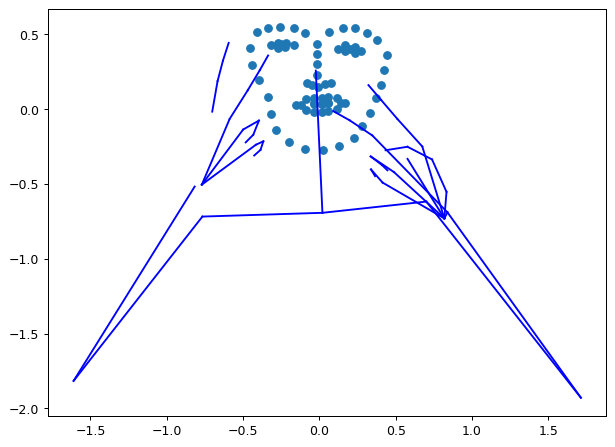

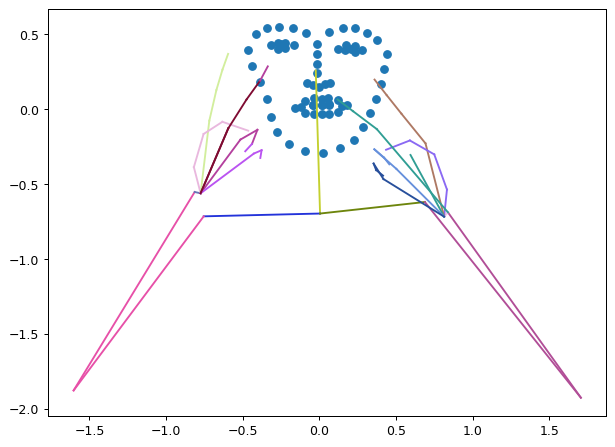

In [38]:
get_video(dataset.__getitem__(0)['poses'], "./src/Bhagyashree Experiments/output_movies/video_with_faces.mp4")

In [ ]:
data = json.load(open(os.path.join('data/interim/Training Data/2D Data/','01576.json')))
max_count = max([int(i) for i in list(data.keys())])
actual_count = 0
temp = []
for count in data.keys():
  if len(data[count]['people']) > 0:
      t = data[count]['people'][0]['pose_keypoints_2d'][:24:] + data[count]['people'][0]['hand_left_keypoints_2d'] + data[count]['people'][0]['hand_right_keypoints_2d'] + [actual_count / max_count] + [0]
      temp.append(t)
      actual_count += 1
temp = np.array(temp)
n = temp.shape[-1] - 2
X = temp[:, 0:n:3]
Y = temp[:, 1:n:3]
W = temp[:, 2:n:3]
# normalization
X, Y = normalization(X, Y)
# Delete all skeletal models which have a lot of missing parts.
X, Y, W = prune(X, Y, W, (0, 1, 2, 3, 4, 5, 6, 7), 0.3, "float32")
# Preliminary filtering: weighted linear interpolation of missing points.
X, Y, W = interpolation(X, Y, W, 0.99, "float32")
arr = np.append(convList2Array([X, Y]),temp[:,-2:], axis=1)
padded_input = np.zeros((max_sequence_length - len(arr), len(arr[0])))
padded_input[:, -2] = pad
arr = np.vstack((arr, padded_input))
print(arr.shape)

In [ ]:
# arr = torch.tensor(arr)
# target = torch.zeros(1, 185, 102)
# source = torch.ones(1, arr.shape[0], 102)
# target[:, 0:arr.shape[0], :] = source
encoder_input = torch.tensor(embeddings_dict["agree"], dtype=torch.float32).unsqueeze(0)
decoder_input = torch.zeros(185,102).unsqueeze(0)
noise = Variable(torch.randn((encoder_input.shape[0], encoder_input.shape[1])))
decoder_input[0][0] = encoder_input #arr[0]
encoder_input = torch.cat((encoder_input,noise),1)
# torch.zeros((185,102)).unsqueeze(0)

i = 0
model.eval()
other_mask = (torch.zeros(1,1,185) != 0).cuda()
with torch.no_grad():
    while ( i <= 183):
        src = Variable(encoder_input, requires_grad=False).cuda()
        trg = Variable(decoder_input,requires_grad=False).cuda()
        other_mask[0][0][i] = True
        out = model.forward(src, trg, other_mask)
        decoder_input[0,i+1,:] = out[0,i,:]
        i += 1

In [ ]:
# get_video(torch.tensor(arr), 'output_movies_b/adult_true.mp4')

In [ ]:
# get_video(torch.tensor(decoder_input[0]), 'output_movies_b/all_out.mp4')

In [ ]:
trim_frames(decoder_input[0].cuda(), torch.from_numpy(arr).cuda(), output_folder+'output_movies/ag_out_1.mp4',output_folder+'output_movies/ag_gt.mp4')

#GAN

In [33]:
class Generator(nn.Module):
    # initializers
    def __init__(self, pretrained_model, d=128):
        super(Generator, self).__init__()
        self.model = pretrained_model
        self.model_opt = get_std_opt(self.model)

    # forward method
    def forward(self, src, trg = None):
        if trg is not None:
          begin_frame = src[:,:embedding_dim:].unsqueeze(1).to(device)
          trg = torch.cat((begin_frame, trg),axis=1)
          tgt_mask = Variable(subsequent_mask(max_sequence_length + 1),requires_grad=False).to(device)
          padded_mask = (trg[:,:,-counter_index] != pad).unsqueeze(-2)
          other_mask = (padded_mask & tgt_mask).to(device)
          # todo check the way parameters are passed as expected
          # out = model.forward(src, trg[:, :-1], trg_mask[:, :-1, :-1])
          out = self.model.forward(src, trg, other_mask)
          return out
        else:
          # this is for inference
          trg = torch.zeros(1,max_sequence_length+1,pose_dim)
          trg[0][0] = src[0][:embedding_dim:] #arr[0]
          other_mask = (torch.zeros(1,1,max_sequence_length+1) != 0).cuda()
          i = 0
          with torch.no_grad():
              while ( i <= max_sequence_length - 1):
                  src = Variable(src, requires_grad=False).cuda()
                  trg = Variable(trg,requires_grad=False).cuda()
                  other_mask[0][0][i] = True
                  out = model.forward(src, trg, other_mask)
                  trg[0,i+1,:] = out[0,i,:]
                  i += 1
          return trg[0]  

In [34]:
class Print(nn.Module):
  def __init__(self):
    super(Print, self).__init__()

  def forward(self,x):
    print('print',x.shape)
    return x
    
class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            # TRY Removing batch norm or stacking more conv1D
            # check input dim
            # Print(),
            nn.Conv1d(177, d, 10),
            # nn.Conv1d(370, d, 10),            
            nn.LeakyReLU(),
            nn.Conv1d(d, d, 10),
            # nn.BatchNorm1d(d),
            nn.LeakyReLU(),
            nn.Conv1d(d, 1, 10),
            nn.Linear(223, 1),
            nn.Sigmoid()
        )

    def forward(self, input, word):
        input = torch.cat((input,word), 1)
        x = self.discriminate(input)
        return x.squeeze()

In [35]:
adversarial_loss = torch.nn.BCELoss()
regression_loss = torch.nn.MSELoss()
def weight_initialization(m):
    # custom weights initialization for both networks
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform(m.weight.data)
    # elif classname.find('BatchNorm') != -1:
    #     nn.init.xavier_uniform(m.weight.data)
    #     nn.init.xavier_uniform(m.bias.data)
# Initialize Generator and discriminator

# we will pass pre trained transformer model
model = make_model(N=4, d_model_input=500, d_model_output=250, d_ff=1024, h=5, dropout=0.1)
# model = torch.load("")
# TRY : change model and try pretrained or try creating a new transformer
generator = Generator(model)
discriminator = Discriminator()

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weight_initialization)
discriminator.apply(weight_initialization)

lr = 1e-3
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr) #betas=(args.beta1, args.beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr) #betas=(args.beta1, args.beta2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys


In [36]:
def valid_epoch_GAN(valid_iter, generator, discriminator, criterion):
    model.eval()
    total_generative_loss = 0
    total_words = 0
    hand_losses = 0 
    torso_losses = 0
    face_losses = 0
    with torch.no_grad():  
      for i, batch in enumerate(valid_iter):
        embeddings = batch['embedding'].cuda()
        poses = batch['poses'].cuda()

        real_imgs = Variable(poses.type(torch.FloatTensor).cuda())
        
        valid = Variable(torch.ones(real_imgs.shape[0]).cuda(), requires_grad=False)
        
        noise = Variable(torch.randn((real_imgs.shape[0], output_dim)).cuda())
        gen_input = torch.cat((embeddings,noise),1)

        gen_imgs = generator(gen_input, poses)
        #gen_y_for_D = tile(embeddings.cuda().unsqueeze(1), 1, max_sequence_length)
        gen_y_for_D = embeddings.unsqueeze(1)

        g_loss_regression = 100 * regression_loss(gen_imgs[:,:-1:], poses)
        g_loss_adversarial = 0.001 * adversarial_loss(discriminator(gen_imgs[:,1::],gen_y_for_D).squeeze(), valid)
        total_generative_loss += g_loss_regression + g_loss_adversarial
        total_words += embeddings.shape[0]
                
        torso_loss, hand_loss, face_loss = compute_skeleton_losses_by_parts(pred=gen_imgs[:, :-1], ground_truth=poses, criterion=regression_loss)
        torso_losses += torso_loss
        hand_losses += hand_loss
        face_losses += face_loss

    return total_generative_loss / len(valid_iter), {"torso": torso_losses / len(valid_iter), "hand": hand_losses / len(valid_iter), "face": face_losses / len(valid_iter)}

[Epoch 0/3000] [Batch 506/507] [D loss: 0.003351] [G loss: 39.361893]
[Epoch 1/3000] [Batch 506/507] [D loss: 0.000709] [G loss: 18.249435]
[Epoch 2/3000] [Batch 506/507] [D loss: 0.001973] [G loss: 22.758816]
[Epoch 3/3000] [Batch 506/507] [D loss: 0.158362] [G loss: 6.380347]
[Epoch 4/3000] [Batch 506/507] [D loss: 0.070944] [G loss: 6.090679]
[Epoch 5/3000] [Batch 506/507] [D loss: 0.043490] [G loss: 5.301894]
[Epoch 6/3000] [Batch 506/507] [D loss: 0.075971] [G loss: 5.578402]
[Epoch 7/3000] [Batch 506/507] [D loss: 0.661739] [G loss: 6.877241]
[Epoch 8/3000] [Batch 506/507] [D loss: 1.443198] [G loss: 5.700559]
[Epoch 9/3000] [Batch 506/507] [D loss: 0.008714] [G loss: 7.929449]
[Epoch 10/3000] [Batch 506/507] [D loss: 0.090165] [G loss: 5.204837]
[Epoch 11/3000] [Batch 506/507] [D loss: 0.018462] [G loss: 4.816823]
[Epoch 12/3000] [Batch 506/507] [D loss: 0.129015] [G loss: 5.224363]
[Epoch 13/3000] [Batch 506/507] [D loss: 0.001198] [G loss: 3.169341]
[Epoch 14/3000] [Batch 506/

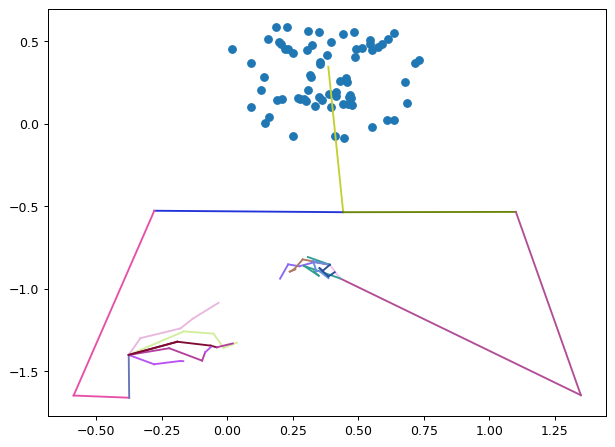

tensor(2.)


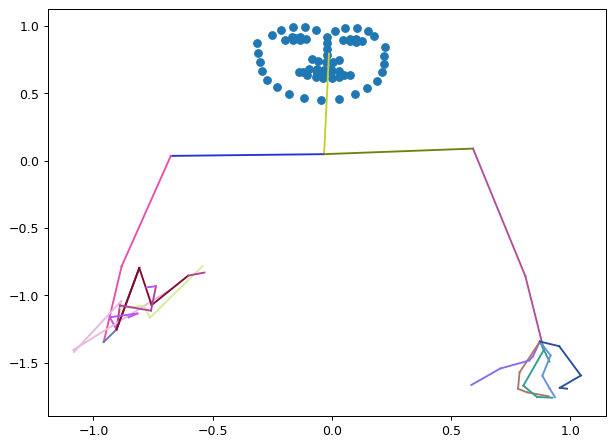

[Epoch 149/3000] [Batch 506/507] [D loss: 0.000026] [G loss: 3.155786]
[Epoch 150/3000] [Batch 506/507] [D loss: 0.000064] [G loss: 1.210052]
[Epoch 151/3000] [Batch 506/507] [D loss: 0.000001] [G loss: 0.964204]
[Epoch 152/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.590632]
[Epoch 153/3000] [Batch 506/507] [D loss: 0.010038] [G loss: 2.460963]
[Epoch 154/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.548079]
[Epoch 155/3000] [Batch 506/507] [D loss: 0.000001] [G loss: 1.999253]
[Epoch 156/3000] [Batch 506/507] [D loss: 0.000664] [G loss: 2.320122]
[Epoch 157/3000] [Batch 506/507] [D loss: 0.000001] [G loss: 3.801053]
[Epoch 158/3000] [Batch 506/507] [D loss: 0.000003] [G loss: 1.327532]
[Epoch 159/3000] [Batch 506/507] [D loss: 0.000001] [G loss: 3.099473]
[Epoch 160/3000] [Batch 506/507] [D loss: 0.000411] [G loss: 2.091596]
[Epoch 161/3000] [Batch 506/507] [D loss: 0.000020] [G loss: 2.318830]
[Epoch 162/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.477718]
[Epoch

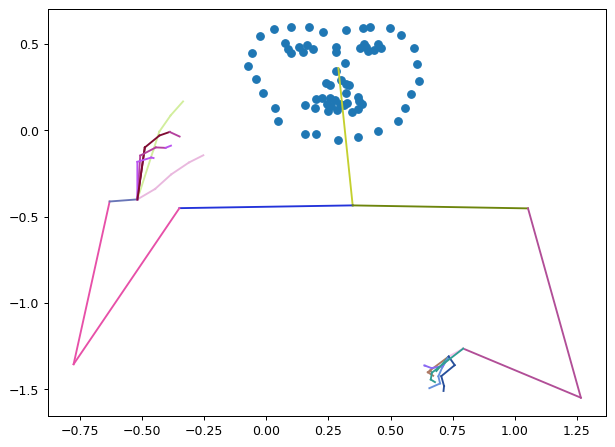

tensor(2.)


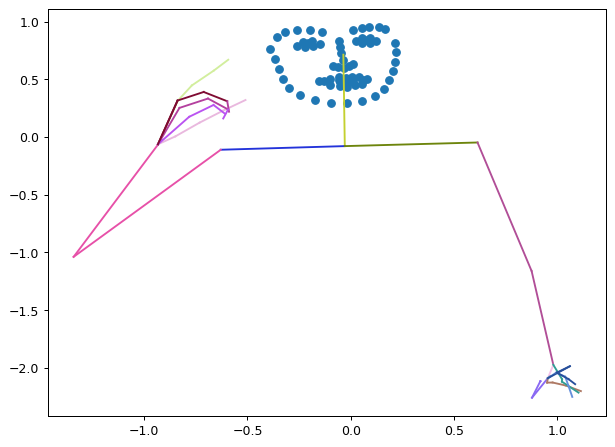

[Epoch 299/3000] [Batch 506/507] [D loss: 0.000006] [G loss: 1.176372]
[Epoch 300/3000] [Batch 506/507] [D loss: 0.000137] [G loss: 1.713445]
[Epoch 301/3000] [Batch 506/507] [D loss: 0.000006] [G loss: 1.809738]
[Epoch 302/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.851066]
[Epoch 303/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.588041]
[Epoch 304/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.452260]
[Epoch 305/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.380659]
[Epoch 306/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.887898]
[Epoch 307/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.839737]
[Epoch 308/3000] [Batch 506/507] [D loss: 0.000295] [G loss: 2.305142]
[Epoch 309/3000] [Batch 506/507] [D loss: 0.000085] [G loss: 2.385186]
[Epoch 310/3000] [Batch 506/507] [D loss: 0.000004] [G loss: 1.765474]
[Epoch 311/3000] [Batch 506/507] [D loss: 0.000196] [G loss: 2.797560]
[Epoch 312/3000] [Batch 506/507] [D loss: 0.189860] [G loss: 1.441411]
[Epoch

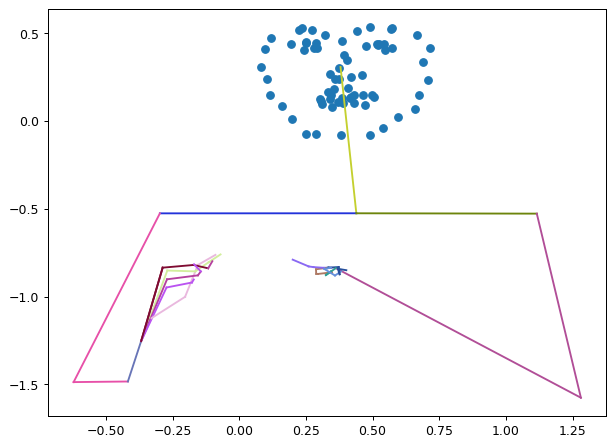

tensor(2.)


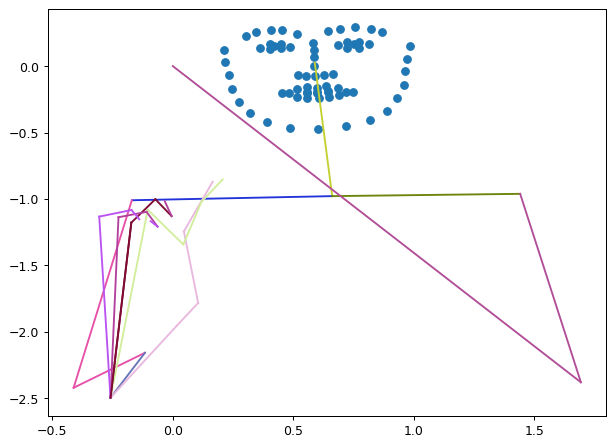

[Epoch 449/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.512587]
[Epoch 450/3000] [Batch 506/507] [D loss: 0.000200] [G loss: 1.290797]
[Epoch 451/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.541829]
[Epoch 452/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.344266]
[Epoch 453/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.432298]
[Epoch 454/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.959119]
[Epoch 455/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.656293]
[Epoch 456/3000] [Batch 506/507] [D loss: 0.000044] [G loss: 1.036377]
[Epoch 457/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.667252]
[Epoch 458/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.512990]
[Epoch 459/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.549707]
[Epoch 460/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.344001]
[Epoch 461/3000] [Batch 506/507] [D loss: 0.000006] [G loss: 1.394851]
[Epoch 462/3000] [Batch 506/507] [D loss: 0.000010] [G loss: 0.848062]
[Epoch

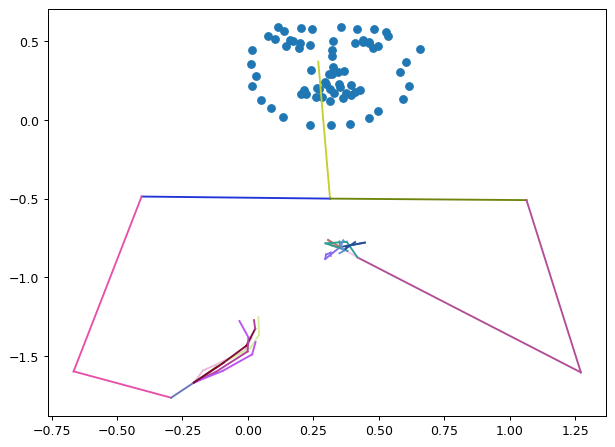

tensor(2.)


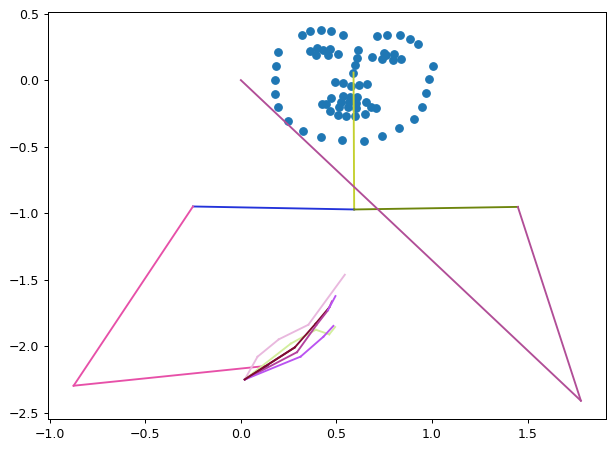

[Epoch 599/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.545836]
[Epoch 600/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 3.608615]
[Epoch 601/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 3.335453]
[Epoch 602/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 6.548984]
[Epoch 603/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.554750]
[Epoch 604/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.563941]
[Epoch 605/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.886795]
[Epoch 606/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.465644]
[Epoch 607/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.968627]
[Epoch 608/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.767973]
[Epoch 609/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.795402]
[Epoch 610/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.245089]
[Epoch 611/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.598437]
[Epoch 612/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.610903]
[Epoch

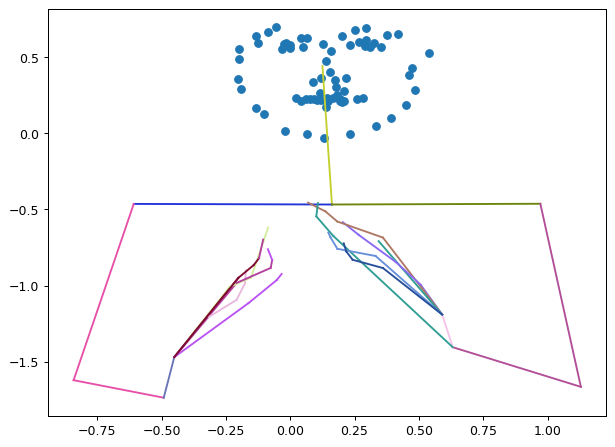

tensor(2.)


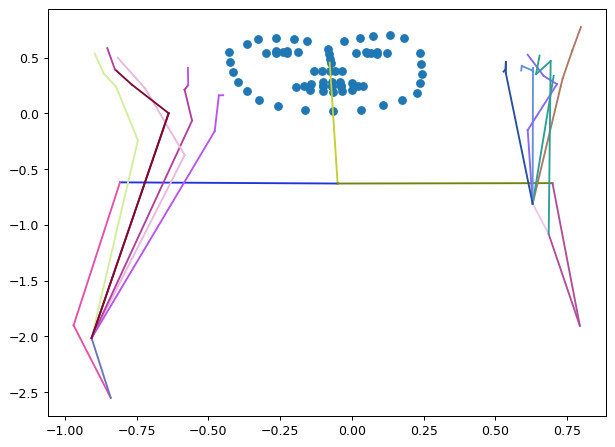

[Epoch 749/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.317215]
[Epoch 750/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.725220]
[Epoch 751/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.795178]
[Epoch 752/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.531637]
[Epoch 753/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 4.228927]
[Epoch 754/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.086265]
[Epoch 755/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.954234]
[Epoch 756/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.560730]
[Epoch 757/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.286536]
[Epoch 758/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.443546]
[Epoch 759/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.560460]
[Epoch 760/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.357904]
[Epoch 761/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.689058]
[Epoch 762/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.644787]
[Epoch

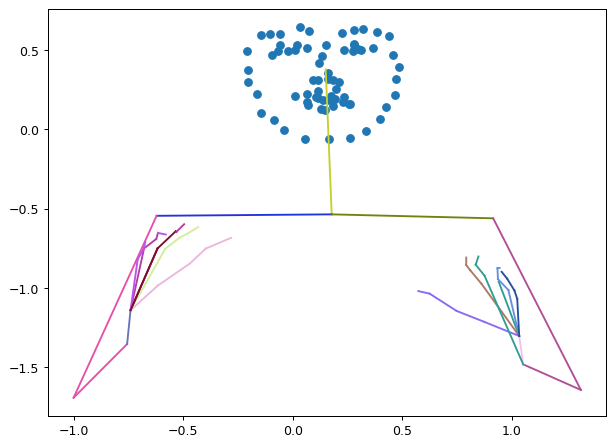

tensor(2.)


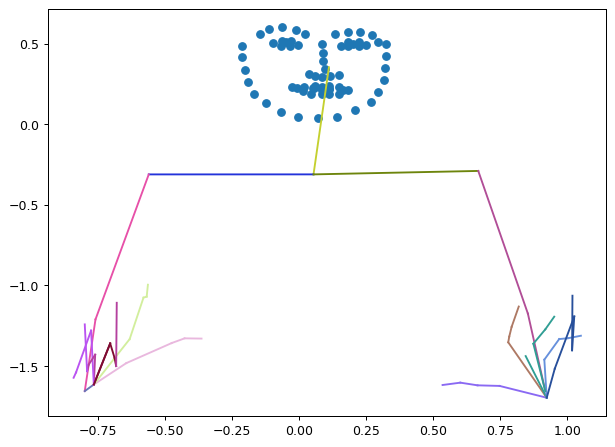

[Epoch 899/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.995996]
[Epoch 900/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.768765]
[Epoch 901/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.309764]
[Epoch 902/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.521771]
[Epoch 903/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.159594]
[Epoch 904/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.380682]
[Epoch 905/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.542016]
[Epoch 906/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.589164]
[Epoch 907/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.443448]
[Epoch 908/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.268236]
[Epoch 909/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 3.578356]
[Epoch 910/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.306693]
[Epoch 911/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.905629]
[Epoch 912/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.666020]
[Epoch

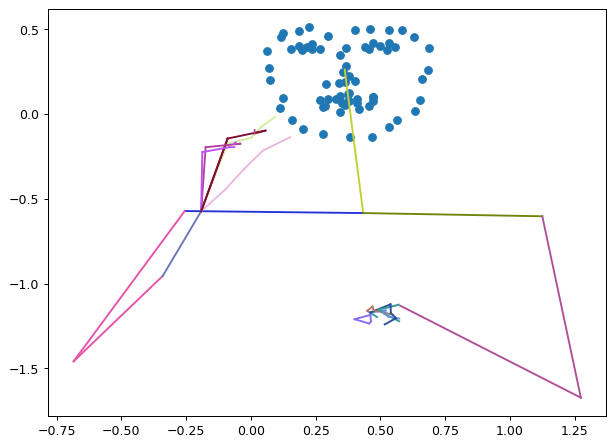

tensor(2.)


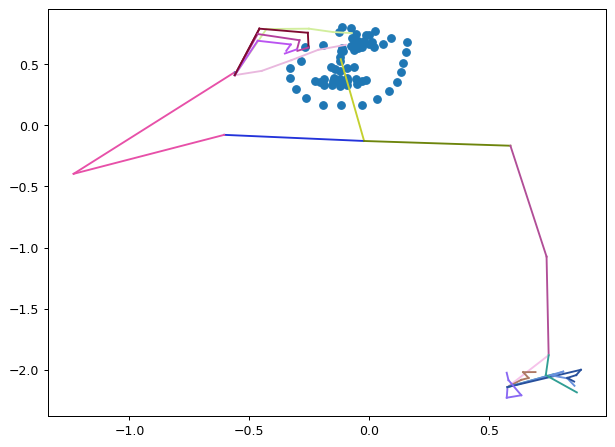

[Epoch 1049/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 3.037747]
[Epoch 1050/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.564381]
[Epoch 1051/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.358728]
[Epoch 1052/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.077610]
[Epoch 1053/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.545323]
[Epoch 1054/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.550647]
[Epoch 1055/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.399482]
[Epoch 1056/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.303182]
[Epoch 1057/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 0.779456]
[Epoch 1058/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.395161]
[Epoch 1059/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.373231]
[Epoch 1060/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.601669]
[Epoch 1061/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 2.494180]
[Epoch 1062/3000] [Batch 506/507] [D loss: 0.000000] [G loss: 1.

KeyboardInterrupt: ignored

In [37]:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42
n_epochs = 3000
output_dim = 250
sample_interval = 150
pose_dim = 250
embedding_dim = 250
generator_losses = []
discriminator_losses = [] 
generator_validation_losses = []
skeleton_part_validation_losses = []

hand_losses = []
torso_losses = []
face_losses = []
for epoch in range(n_epochs):
    generator_loss = 0
    discriminator_loss = 0
    hand_loss = 0
    torso_loss = 0
    face_loss = 0
    for i, batch in enumerate(train_loader):
        embeddings = batch['embedding'].cuda()
        poses = batch['poses'].cuda()
        
        # Configure input
        real_imgs = Variable(poses.type(torch.FloatTensor).cuda())
        real_y = torch.ones(real_imgs.shape[0],output_dim).cuda()
        # real_y = real_y.scatter_(1, labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class, 1, 1).contiguous()
        real_y = Variable(real_y.cuda())

        
        valid = Variable(torch.ones(real_imgs.shape[0]).cuda(), requires_grad=False)
        fake = Variable(torch.zeros(real_imgs.shape[0]).cuda(), requires_grad=False)

        # Sample noise and labels as generator input
        # noise = Variable(torch.randn((Batch_Size, output_dim)).cuda())
        # gen_labels = (torch.rand(Batch_Size, 1) * N_Class).type(torch.LongTensor)
        # check 1 dim
        # gen_y = Variable(gen_y.scatter_(1, gen_labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class,1,1).cuda())
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Loss for real images
        # gen_y = tile(gen_y.unsqueeze(2), 2, max_sequence_length).reshape(-1, 185, 364)
        # print(gen_y.unsqueeze(1).shape, real_imgs.shape)

        # gen_y = tile(embeddings.cuda().unsqueeze(1), 1, max_sequence_length)
        gen_y = embeddings.unsqueeze(1)
        # print(gen_y.shape)
        d_real_loss = adversarial_loss(discriminator(real_imgs, gen_y), valid) #batch x 185 x 364; batch x 300
        # Loss for fake images
        # TRY change noise dimension according to the pretrained or according to what is passed in make model
        noise = Variable(torch.randn((real_imgs.shape[0], output_dim)).cuda())
        gen_input = torch.cat((embeddings,noise),1)
        gen_imgs = generator(gen_input, poses)
        # gen_y_for_D = tile(embeddings.cuda().unsqueeze(1), 1, max_sequence_length)
        gen_y_for_D = embeddings.unsqueeze(1)
        # gen_y_for_D = gen_y.view(Batch_Size, N_Class, 1, 1).contiguous().expand(-1, -1, img_size, img_size)
        d_fake_loss = adversarial_loss(discriminator(gen_imgs.detach()[:,1:],gen_y_for_D), fake)
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss)
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # TRY different weights for regression loss weights
        g_loss_regression = 1000 * regression_loss(gen_imgs[:,:-1:], poses)
        g_loss_adversarial = 0.001 * adversarial_loss(discriminator(gen_imgs[:,1::],gen_y_for_D).squeeze(), valid)
        # total_genereator_loss = 100 * g_loss_regression + 0.001 * g_loss_adversarial
        total_generator_loss = g_loss_regression + g_loss_adversarial
        total_generator_loss.backward()
        optimizer_G.step()

        generator_loss += total_generator_loss
        discriminator_loss += d_loss

                
        batch_torso_loss, batch_hand_loss, batch_face_loss = compute_skeleton_losses_by_parts(pred=gen_imgs[:, :-1], ground_truth=poses, criterion=regression_loss)
        torso_loss += batch_torso_loss
        hand_loss += batch_hand_loss
        face_loss += batch_face_loss

        batches_done = epoch * len(train_loader) + i
    if (epoch+1) % sample_interval == 0:
        # fixed labels
        sample_embedding = embeddings[0:1]
        sample_poses = poses[0:1]
        noise = Variable(torch.randn((sample_embedding.shape[0], output_dim)).cuda())
        gen_input = torch.cat((sample_embedding,noise),1)
        gen_imgs = generator(gen_input)
        # save_image(gen_imgs.data, img_save_path + '/%d-%d.png' % (epoch,batches_done), nrow=N_Class, normalize=True)
        trim_frames(gen_imgs[:-1:],sample_poses[0],output_folder+"/output_movies/gen_output"+str(epoch)+".mp4",output_folder+"/output_movies/gen_gt"+str(epoch)+".mp4")

        discriminator_losses.append(discriminator_loss / len(train_loader))
        generator_losses.append(generator_loss/len(train_loader))
        hand_losses.append(hand_loss/len(train_loader))
        torso_losses.append(torso_loss/len(train_loader))
        face_losses.append(face_loss/len(train_loader))
 
        generator_validation_loss, skeleton_part_val_loss = valid_epoch_GAN(validation_loader, generator, discriminator, regression_loss)
        generator_validation_losses.append(generator_validation_loss)
        skeleton_part_validation_losses.append(skeleton_part_val_loss)

    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(train_loader), d_loss.data.cpu(), total_generator_loss.data.cpu()))
    

# plotting the losses
print(generator_losses,discriminator_losses)
plot_losses(generator_losses,"Generator Loss")
plot_losses(discriminator_losses,"Discriminator Loss")
plot_losses(generator_validation_losses,"Generator Validation Loss")

version = "v1"
notes = "first pass at running the base GAN model."
#set where you want to save this.
with open(output_folder + f"gan.all.losses.{version}.pkl", "wb") as f:
  pickle.dump({
      "generator_train_loss": generator_losses,
      "discriminator_train_loss": discriminator_losses,
      "generator_val_loss": generator_validation_losses,
      "train_skeleton_part_loss": {"hand": hand_losses, "torso": torso_losses, "face": face_losses},
      "val_skeleton_part_loss": skeleton_part_validation_losses,
      "notes": notes
  }, f)

In [39]:
torch.save(model, 'src/Bhagyashree Experiments/gan_without_pretrained_transformer_500_250.pkl')

# A Real World Example

In [ ]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.
#Todo if not necessary remove later
BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

In [ ]:
# Create the model an load it onto our GPU.
model = make_model()
model_opt = get_std_opt(model)
model.cuda()

In [ ]:

criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
    valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)


OTHER

In [ ]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field()
TGT = data.Field(init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD) # only target needs BOS/EOS

MAX_LEN = 100
train = datasets.TranslationDataset(path="/n/home00/srush/Data/baseline-1M_train.tok.shuf", 
                                    exts=('.en', '.fr'),
                                    fields=(SRC, TGT), 
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
SRC.build_vocab(train.src, max_size=50000)
TGT.build_vocab(train.trg, max_size=50000)

In [ ]:
pad_idx = TGT.vocab.stoi["<blank>"]
print(pad_idx)
model = make_model(len(SRC.vocab), len(TGT.vocab), pad_idx, N=6)
model_opt = get_opt(model)
model.cuda()

In [ ]:
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)
    valid_epoch()

In [ ]:
print(pad_idx)
print(len(SRC.vocab))

In [ ]:
torch.save(model, "/n/rush_lab/trans_ipython.pt")

In [ ]:
#weight = torch.ones(len(TGT.vocab))
#weight[pad_idx] = 0
#criterion = nn.NLLLoss(size_average=False, weight=weight.cuda())
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)

In [ ]:
1 10.825187489390373 6.987712429686844e-07
101 9.447168171405792 3.56373333914029e-05
201 7.142856806516647 7.057589553983712e-05
301 6.237934365868568 0.00010551445768827134
401 5.762486848048866 0.00014045301983670557
501 5.415792358107865 0.00017539158198513977
601 5.081815680023283 0.000210330144133574
701 4.788327748770826 0.00024526870628200823
801 4.381739928154275 0.0002802072684304424
901 4.55433791608084 0.00031514583057887664
1001 4.911875109748507 0.0003500843927273108
1101 4.0579032292589545 0.0003850229548757451
1201 4.2276234351193125 0.0004199615170241793
1301 3.932735869428143 0.00045490007917261356
1401 3.8179439397063106 0.0004898386413210477
1501 3.3608515430241823 0.000524777203469482
1601 3.832796103321016 0.0005597157656179162
1701 2.907085266895592 0.0005946543277663504
1801 3.5280659823838505 0.0006295928899147847
1901 2.895841649500653 0.0006645314520632189
2001 3.273784235585481 0.000699470014211653
2101 3.181488689899197 0.0007344085763600873
2201 3.4151616653980454 0.0007693471385085215
2301 3.4343731447588652 0.0008042857006569557
2401 3.0505455391539726 0.0008392242628053899
2501 2.8089329147478566 0.0008741628249538242
2601 2.7827929875456903 0.0009091013871022583
2701 2.4428516102489084 0.0009440399492506926
2801 2.4015486147254705 0.0009789785113991267
2901 2.3568112018401735 0.001013917073547561
3001 2.6349758653668687 0.0010488556356959952
3101 2.5981983028614195 0.0010837941978444295
3201 2.666826274838968 0.0011187327599928637
3301 3.0092043554177508 0.0011536713221412978
3401 2.4580375660589198 0.0011886098842897321
3501 2.586465588421561 0.0012235484464381662
3601 2.5663993963389657 0.0012584870085866006
3701 2.9430236657499336 0.0012934255707350347
3801 2.464644919440616 0.001328364132883469
3901 2.7124062888276512 0.0013633026950319032
4001 2.646443709731102 0.0013971932312809247
4101 2.7294750874862075 0.001380057517579748
4201 2.1295202329056337 0.0013635372009002666
4301 2.596563663915731 0.001347596306985731
4401 2.1265982036820787 0.0013322017384983986
4501 2.3880532500334084 0.0013173229858148
4601 2.6129120760888327 0.0013029318725783852
4701 2.2873719420749694 0.001289002331178292
4801 2.4949760700110346 0.0012755102040816328
4901 2.496607314562425 0.001262433067573089
5001 2.1889712483389303 0.0012497500749750088
5101 1.8677761815488338 0.0012374418168536253
5201 2.2992054556962103 0.0012254901960784316
5301 2.664361578106707 0.0012138783159049418
5401 2.705850490485318 0.0012025903795063202
5501 2.581445264921058 0.0011916115995949978
5601 2.2480602325085783 0.0011809281169581616
5701 1.9289666265249252 0.0011705269268863989
5801 2.4863578918157145 0.0011603958126073107
5901 2.632946971571073 0.0011505232849492607
6001 2.496141305891797 0.0011408985275576757
6101 2.6422974687084206 0.0011315113470699342
6201 2.448802186456305 0.0011223521277270118

In [ ]:
temp = torch.Tensor([[[1,1,0,-1],[-1,-1,2,3],[1,0,2,3]],
                     [[1,-1,2,3],[-1,1,2,3],[0,0,2,3]],
                     [[2,-2,2,3],[-2,2,2,3],[0,2,2,3]],
                     [[2,0,2,3],[-2,0,2,3],[0,-2,2,3]]
                     ])
extra = torch.Tensor([[[1,1,1,1]],
                     [[1,1,1,1]],
                     [[1,1,1,1]],
                     [[1,1,1,1]]
                     ])
print(temp.size())
print(temp)
t = temp.repeat(1,5)
print(t.size())
print(t)
'''
temp = torch.cat((temp, extra),axis = 1)
print(temp)
#u = torch.where(temp[:,:,1:2]>=1, temp, torch.zeros_like(temp))
#print(u)
x_centers = torch.unsqueeze(temp[:,:,0],axis = 2)
y_centers = torch.unsqueeze(temp[:,:,1],axis = 2)
#print(x_centers,y_centers)
centers = torch.cat((x_centers,y_centers), 2).repeat(repeats=(1,1,temp.size()[2]-2))
centers[:,:, -1::] = 0
print(centers)
temp -= centers
print(temp)   
# indices_of_one = torch.where(temp[:,:,1] >= 1.0,temp,torch.zeros(3,2))
# print(indices_of_one)
# temp = torch.where(temp <= 1, temp, torch.zeros(4,3,2))
# print(temp)
'''

In [ ]:
real_y = torch.zeros(16, 10)
real_y = real_y.scatter_(1, labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class, 1, 1).contiguous()
real_y = Variable(real_y.expand(-1, -1, img_size, img_size).cuda())

In [ ]:
def load_embeddings():
    word_embeddings = []
    words = []
    with (open("data/interim/embeddings.pkl", "rb")) as openfile:
        while True:
            try:
                word_embeddings.append(pickle.load(openfile))
            except EOFError:
                break
    with (open("./data/interim/words.pkl", "rb")) as openfile:
        while True:
            try:
                words.append(pickle.load(openfile))
            except EOFError:
                break
    return word_embeddings, words

def get_word_embedding(word, word_embeddings, words):
    indices = np.argwhere(words[0] == word)[0]
    return word_embeddings[0][indices[0]]



In [ ]:
encoder_input = torch.tensor(embeddings_dict['all'], dtype=torch.float32).unsqueeze(0)
decoder_input = torch.zeros(185,102).unsqueeze(0)
# torch.zeros((185,102)).unsqueeze(0)

i = 0
model.eval()
other_mask = (torch.zeros(1,1,185) != 0).cuda()
with torch.no_grad():
    while ( i <= 183):
        src = Variable(encoder_input, requires_grad=False).cuda()
        trg = Variable(decoder_input,requires_grad=False).cuda()
        other_mask[0][0][i] = True
        out = model.forward(src, trg, other_mask)
        decoder_input[0,i+1,:] = out[0,i,:]
        i += 1
        # print(i)